In [1]:
!nvidia-smi

Wed Aug  7 09:28:26 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:43:00.0 Off |                  Off |
| 30%   35C    P8    21W / 300W |      0MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 xformers==0.0.22.post7+cu118 --index-url https://download.pytorch.org/whl/cu118

In [3]:
from PIL import Image
import PIL
import os
import os.path
import numpy as np
import torch.utils.data as data
import matplotlib.image as mpimg
from torchvision import transforms


class MVTEC(data.Dataset):
    """`MVTEC <https://www.mvtec.com/company/research/datasets/mvtec-ad/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directories
            ``bottle``, ``cable``, etc., exists.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        resize (int, optional): Desired output image size.
        interpolation (int, optional): Interpolation method for downsizing image.
        category: bottle, cable, capsule, etc.
    """


    def __init__(self, root, train=True,
                 transform=None, target_transform=None, mask_transform = None,
                 category='carpet', resize=None, interpolation=2):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.mask_transform = mask_transform
        self.target_transform = target_transform
        self.train = train
        self.resize = resize
        self.interpolation = interpolation
        
        # load images for training
        if self.train:
            self.train_data = []
            self.train_labels = []
            cwd = os.getcwd()
            trainFolder = self.root+'/'+category+'/train/good/'
            os.chdir(trainFolder)
            filenames = [f.name for f in os.scandir()]
            for file in filenames:
                img = mpimg.imread(file)
                img = img*255
                img = img.astype(np.uint8)
                self.train_data.append(img)
                self.train_labels.append(1)                 
            os.chdir(cwd)
                
            self.train_data = np.array(self.train_data)      
        else:
        # load images for testing
            self.test_data = []
            self.test_labels = []
            self.test_gt = []
            self.test_subclass = []
            
            cwd = os.getcwd()
            testFolder = self.root+'/'+category+'/test/'
            gtFolder = self.root+'/'+category+'/ground_truth/'
            os.chdir(testFolder)
            subfolders = [sf.name for sf in os.scandir() if sf.is_dir()]
            cwsd = os.getcwd()
            
            # for every subfolder in test folder
            for subfolder in subfolders:
                label = 0
                if subfolder == 'good':
                    label = 1
                testSubfolder = './'+subfolder+'/'
                gtSubfolder = gtFolder+subfolder+'/'
                os.chdir(testSubfolder)
                filenames = [f.name for f in os.scandir() if f.is_file()]
                for file in filenames:
                    img = np.array(PIL.Image.open(file).convert('RGB'))
                    img = img.astype(np.uint8)
                    if label==1:
                        mask = np.zeros(shape=(resize, resize))
                        mask = mask.astype(np.uint8)
                    else:
                        mask = np.array(PIL.Image.open(gtSubfolder+file[:-4]+'_mask.png'))
                        mask = mask.astype(np.uint8)
                    self.test_data.append(img)
                    self.test_labels.append(label)
                    self.test_gt.append(mask)
                    self.test_subclass.append(subfolder)
                os.chdir(cwsd)
            os.chdir(cwd)
                
            self.test_data = np.array(self.test_data)
                
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, mask, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
            mask, damage_class = None, None
        else:
            img, mask, target, damage_class = self.test_data[index], self.test_gt[index], self.test_labels[index], self.test_subclass[index]

        img = Image.fromarray(img)
        mask = Image.fromarray(mask)
        
        #if resizing image
        if self.resize is not None:
            resizeTransf = transforms.Resize(self.resize, self.interpolation)
            img = resizeTransf(img)
            mask = resizeTransf(mask)

        if self.transform is not None:
            img = self.transform(img)
            
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, mask, target, damage_class

    def __len__(self):
        """
        Args:
            None
        Returns:
            int: length of array.
        """
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-y_v6somh because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
class ThresholdTransform(object):
    def __init__(self, thr_255):
        self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

    def __call__(self, x):
        return (x > self.thr).to(x.dtype)  # do not change the data typ

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
mask_transform = transforms.Compose(
    [transforms.ToTensor(),
     ThresholdTransform(thr_255=0)
                            ])

batch_size = 1

im_shape = 512

# Interpolation method for resizing the image
interpol = 3

# Data category to use: carpet, leather, wood, bottle, etc.
cat = 'grid'


testset = MVTEC(root='/home/jovyan/work/nfs/mvtec/mvtec', train=False, transform=transform,
                mask_transform=mask_transform,
                    resize=im_shape, interpolation=interpol, category=cat)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

# Each category has two types of images: good (label 1) or defective (label 0)
classes = ('defective', 'good')

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def tensor2numpy(img, mask=False):
    if not mask:
        img = img / 2 + 0.5
    npimg = img.squeeze(0).numpy()
    return np.transpose(npimg, (1, 2, 0))

In [8]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_and_masks(images, masks, labels, classes, damage_types, N=5):
    """
    Plot N examples of images and their corresponding masks in two rows.
    
    Parameters:
    - images: Tensor or array of images.
    - masks: Tensor or array of masks.
    - labels: Tensor or array of labels.
    - classes: List of class names.
    - damage_types: List of specific damage types.
    - N: Number of examples to plot (default is 5).
    """
    
    fig, axes = plt.subplots(2, N, figsize=(3*N, 6))
    
    for i in range(N):
        # Show images
        img = images[i]
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Image: {classes[labels[i]]}")
        axes[0, i].axis('off')
        
        # Show masks
        mask = masks[i]
        axes[1, i].imshow(img)
        axes[1, i].imshow(mask, cmap='jet', alpha=0.3)
        axes[1, i].set_title(f"Mask: {classes[labels[i]]} \n Damage: {damage_types[i]}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

dataiter = iter(testloader)

N = 5
images = []
masks = []
labels = []
damage_types = []

for _ in range(N):
    img, mask, label, damage_class = next(dataiter)
    images.append(tensor2numpy(img))
    masks.append(tensor2numpy(mask, mask=True))
    labels.append(label)
    damage_types.append(damage_class[0])

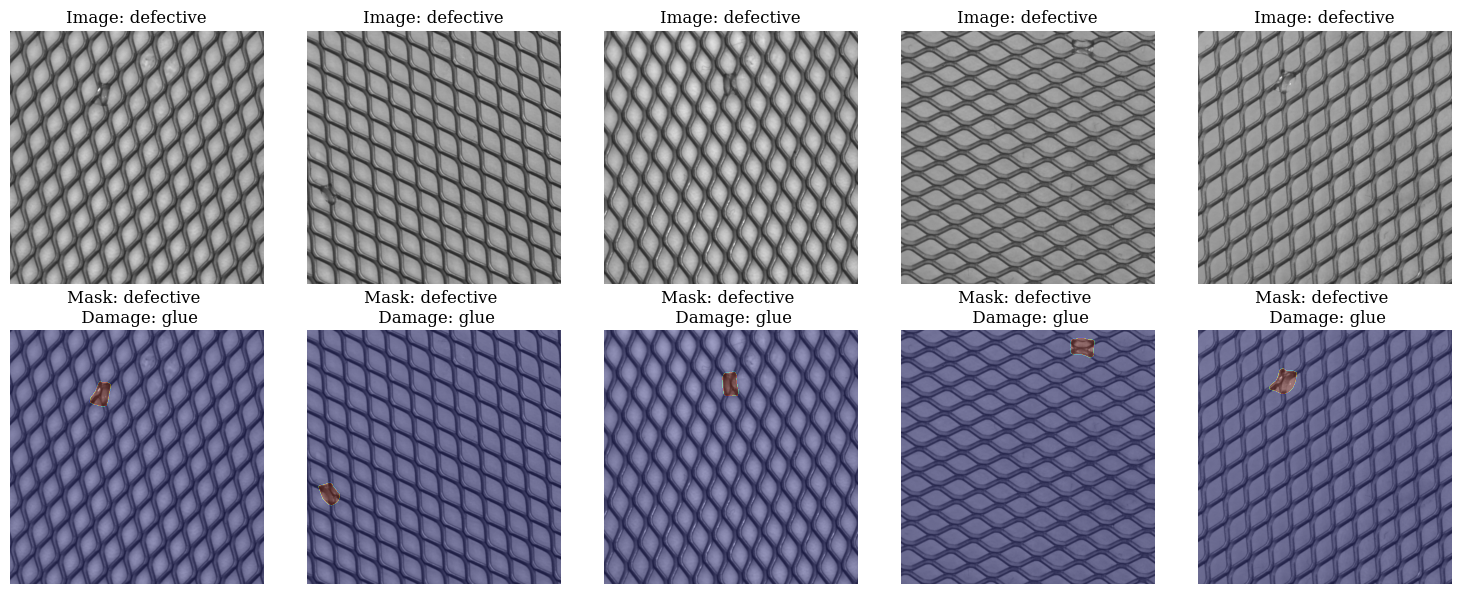

In [10]:
# Assuming classes is defined and contains the class names
plot_images_and_masks(images, masks, labels, classes, damage_types, N=N)

In [11]:
import torch
import diffusers
torch.__version__

'2.1.0+cu118'

In [12]:
!export PATH="$HOME/.local:$PATH"
!export PATH="$HOME/.local/bin:$PATH"
import sys
sys.path.append('/home/jovyan/.local/lib/python3.8/site-packages')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [13]:
device

device(type='cuda', index=0)

In [14]:
import torch
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler
import numpy as np

from ovam import StableDiffusionHooker
from ovam.stable_diffusion_sa.pipeline_hooker_sa import StableDiffusionHookerSA
from ovam.utils import set_seed, get_device
from ovam.optimize import optimize_embedding
from ovam.utils.dcrf import densecrf


def load_image(path, size=None):
    img = Image.open(path).convert("RGB")
    if size is not None:
        img = img.resize(size)
    return img

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [15]:
from MidpointSD import MidpointStableDiffusionPipeline

In [16]:
pipe = MidpointStableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", safety_checker=None).to(device)
# Set up a DDIM scheduler
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'MidpointSD.MidpointStableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [17]:
img, mask, label, damage_type = next(dataiter)

In [18]:
input_image_prompt = cat

In [19]:
start_latent = pipe.image2latent(img, device=device)

In [20]:
start_latent.shape

torch.Size([1, 4, 64, 64])

In [21]:
start_latent.device

device(type='cuda', index=0)

In [22]:
start_step = 47 # Invert until t

inverted_latents = pipe.invert(start_latent, input_image_prompt, num_inference_steps=50, guidance_scale=1., device=device, stop_step=start_step)
inverted_latents.shape

/home/jovyan/work/nfs/code/ovam/nbs/MVTEC-OVAM/MidpointSD.py:271: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1, 4, 64, 64])

In [23]:
plt.imshow(tensor2numpy(img))

In [24]:
with StableDiffusionHookerSA(pipe, extract_self_attentions=True) as hooker:
    set_seed(420)
    out = pipe(input_image_prompt, latents=inverted_latents[-1][None], num_inference_steps=50, guidance_scale=1., start_step=start_step)
    images = out.images

  0%|          | 0/3 [00:00<?, ?it/s]

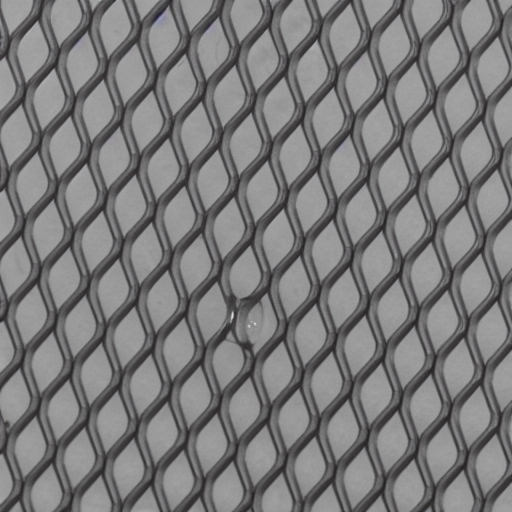

In [25]:
images[0]

In [26]:
import io

def save_axis_as_image(fig, ax):
    buf = io.BytesIO()
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(buf, format='png', bbox_inches=extent)
    buf.seek(0)
    return Image.open(buf)

In [27]:
def plot_word_attn_map(image, inverted_image, mask, attention_maps, prompt, thresh=0.5):
    fig, axes = plt.subplots(1, 5, figsize=(25, 7))

    axes[0].imshow(tensor2numpy(image))
    axes[0].axis("off")
    axes[0].set_title("Image")

    for ax in axes[1:]:
        ax.axis("off")
        ax.imshow(inverted_image)
    axes[1].set_title("Inverted image")
#     for i, word in enumerate(prompt.split(" ")):
    axes[2].set_title(f"Attention map for '{prompt}'")
    axes[3].set_title(f"Thresholded attention map for '{prompt}' at t={thresh}")
    word_attn = attention_maps[1:-1, :, :].mean(axis=0)
    #word_attn = attention_maps[i+1]
    word_attn_norm = word_attn / word_attn.max()
    word_attn_norm_np = word_attn_norm.cpu().numpy()
    word_attn_norm_np = np.repeat(np.repeat(word_attn_norm_np, 512 // 64, axis=1), 512 // 64, axis=0)
    axes[2].imshow(word_attn_norm_np, alpha=word_attn_norm_np, cmap='jet')
    axes[3].imshow((word_attn_norm_np>thresh), alpha=word_attn_norm_np, cmap='jet')

    axes[4].imshow(tensor2numpy(image))
    axes[4].imshow(tensor2numpy((mask>0.0).float(), mask=True), cmap='jet', alpha=0.3)
    axes[4].axis("off")
    axes[4].set_title("GT") 

    fig.tight_layout()
    
    # Save each subplot as a PIL image
    pil_images = [save_axis_as_image(fig, ax) for ax in axes]

    return fig, pil_images, word_attn_norm

In [28]:
ovam_evaluator = hooker.get_ovam_callable(
        heads_epochs_activation = "token_softmax",  # "linear" for linear daam,
        heads_epochs_aggregation = "sum",
        heads_activation = "linear",
        heads_aggregation = "mean",
        block_interpolation_mode = "bilinear",
        blocks_activation = "linear",
        heatmaps_activation = None,
        heatmaps_aggregation = "mean",
        expand_size = None,
        expand_interpolation_mode = "bilinear",
)

In [29]:
with torch.no_grad():
    attention_maps = ovam_evaluator(input_image_prompt)
    attention_maps = attention_maps[0]#.cpu().numpy() # (8, 512, 512)

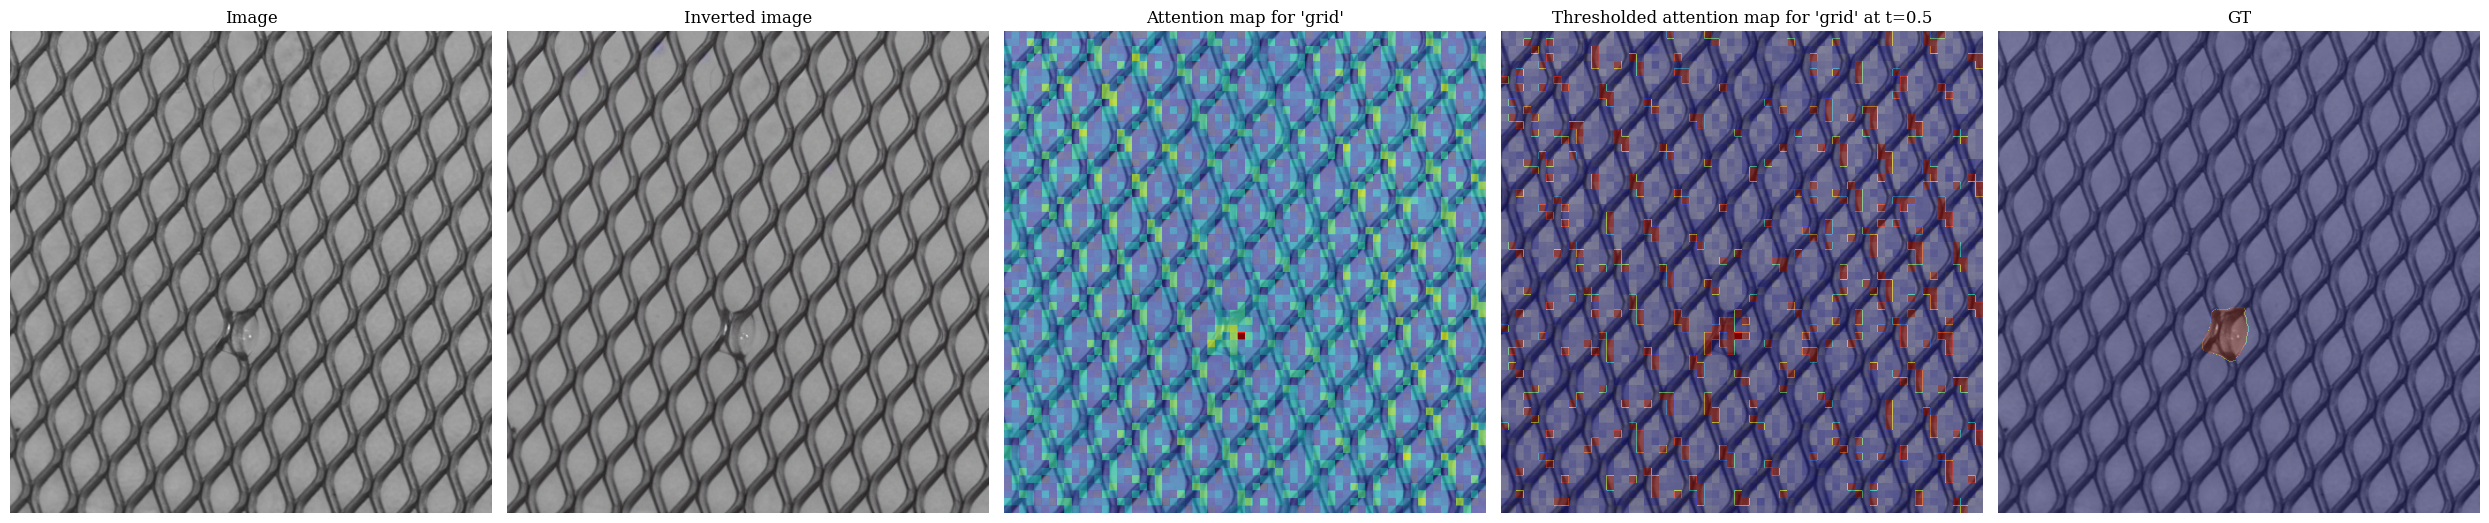

In [30]:
_, pil_images, word_attn_norm_label = plot_word_attn_map(img, images[0], mask, attention_maps, input_image_prompt)

In [31]:
self_attn = hooker.get_self_attention_map(stack=False, rescale=(0,1))

In [32]:
self_attn[9].shape

torch.Size([8, 4096, 40])

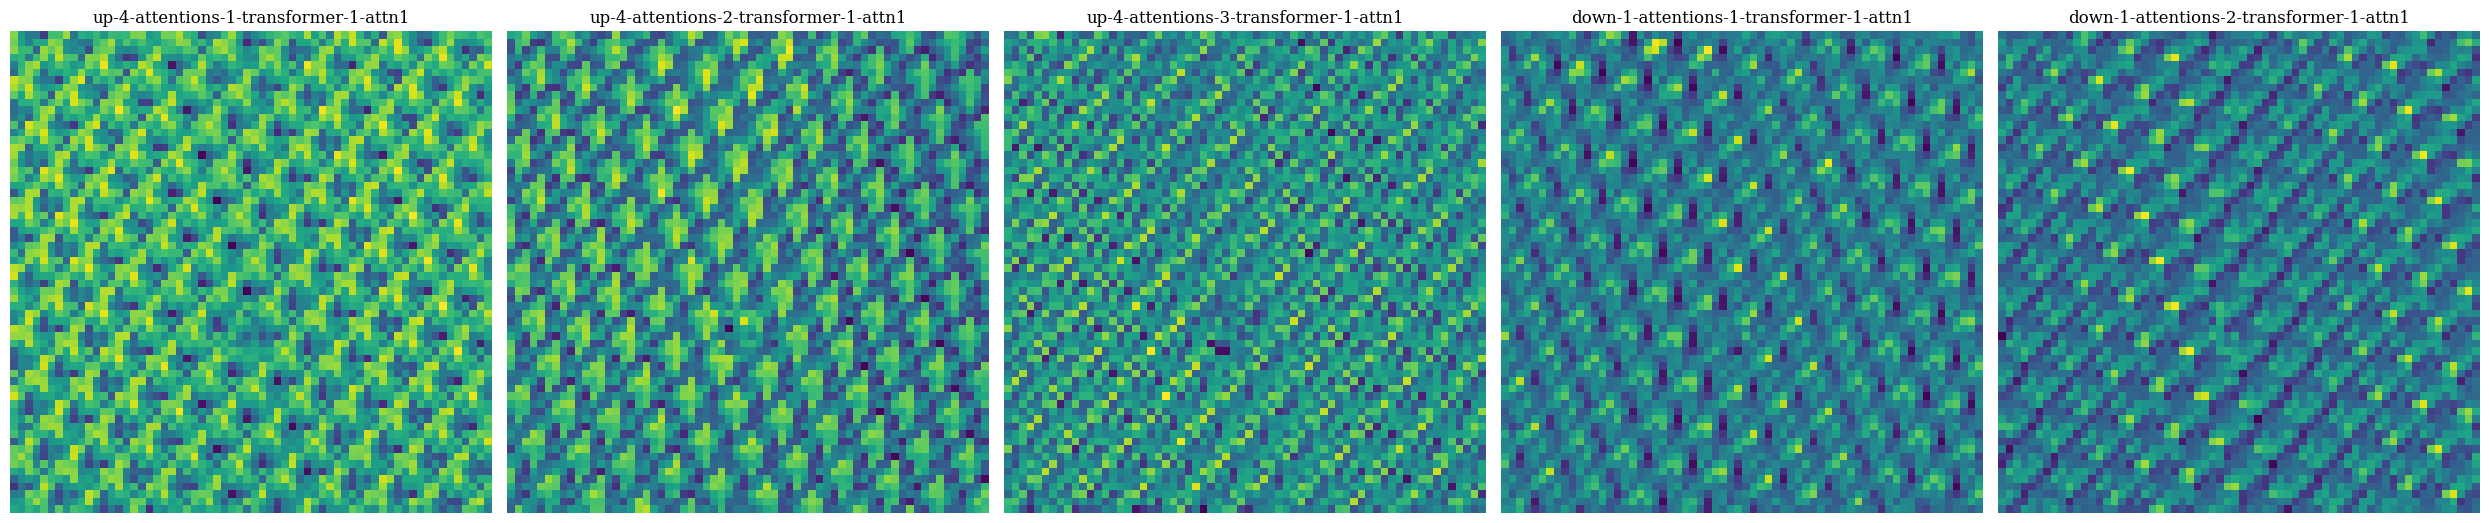

In [33]:
fig, axes = plt.subplots(1, 5, figsize=(25, 7))
ax_i = 0

for h in hooker.self_attention_hookers:
    attn = h._current_hidden_state[-1]
    if attn.shape == (1,8,4096,40):
        axes[ax_i].imshow(attn.squeeze(0).sum(axis=0).sum(axis=-1).reshape(64,64).cpu().numpy())
        axes[ax_i].axis('off')
        axes[ax_i].set_title(f'{h.name}')
        ax_i+=1
fig.tight_layout()

In [34]:
len(self_attn)

15

In [35]:
self_attn_up = [attn.squeeze(0).mean(axis=0) for h in hooker.self_attention_hookers if h.name.startswith('up') for attn in h._current_hidden_state if attn.shape == (1,8,4096,40)]

In [36]:
len(self_attn_up)

9

In [37]:
for sa in self_attn_up:
    print(sa.shape)

torch.Size([4096, 40])
torch.Size([4096, 40])
torch.Size([4096, 40])
torch.Size([4096, 40])
torch.Size([4096, 40])
torch.Size([4096, 40])
torch.Size([4096, 40])
torch.Size([4096, 40])
torch.Size([4096, 40])


In [38]:
self_attn_map = self_attn[10] / self_attn[10].max()
self_attn_map.shape

torch.Size([8, 4096, 40])

In [39]:
extended_prompt = "damage"
with torch.no_grad():
    attention_maps = ovam_evaluator(extended_prompt)
    attention_maps = attention_maps[0]#.cpu().numpy()

In [40]:
print(attention_maps.min(), attention_maps.max())

tensor(0.0115, device='cuda:0') tensor(2.9725, device='cuda:0')


In [41]:
cross_attn_map = attention_maps[1] / attention_maps[1].sum()
print(cross_attn_map.min(), cross_attn_map.max())
cross_attn_map

tensor(0.0001, device='cuda:0') tensor(0.0008, device='cuda:0')


tensor([[0.0002, 0.0003, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0003, 0.0003, 0.0003],
        [0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0003, 0.0002],
        ...,
        [0.0002, 0.0003, 0.0003,  ..., 0.0002, 0.0003, 0.0001],
        [0.0003, 0.0003, 0.0002,  ..., 0.0003, 0.0001, 0.0002],
        [0.0002, 0.0002, 0.0003,  ..., 0.0003, 0.0002, 0.0002]],
       device='cuda:0')

In [42]:
cross_attn_map.shape

torch.Size([64, 64])

In [43]:
self_attn_map.unique()

tensor([-0.9388, -0.8196, -0.8144,  ...,  0.9883,  0.9941,  1.0000],
       device='cuda:0')

In [44]:
plt.imshow((cross_attn_map).cpu().numpy())

In [45]:
_,_, word_attn_norm = plot_word_attn_map(img, images[0], mask, attention_maps, extended_prompt)

In [46]:
word_attn_diff = word_attn_norm-word_attn_norm_label

In [47]:
plt.imshow((word_attn_norm*word_attn_norm_label).cpu().numpy())

In [48]:
def interpolate(heatmap: torch.Tensor, size=(512, 512), mode="bilinear"):
    """Interpolate heatmap to match the size of the ground truth"""
    
    # Add batch and channel dimension
    heatmap = heatmap.unsqueeze(0).unsqueeze(0)
    # Interpolate
    heatmap = torch.nn.functional.interpolate(heatmap, size=size, mode=mode)
    # Convert back 
    heatmap = heatmap.squeeze().squeeze()
    
    return heatmap

In [49]:
word_attn_norm = interpolate(word_attn_diff)

In [50]:
from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex, BinaryAUROC

calc_auroc = BinaryAUROC()
calculate_iou = BinaryJaccardIndex().to(device)
calculate_f1 = BinaryF1Score().to(device)

iou_score = calculate_iou((word_attn_norm>0.5).float(), mask.to(device).squeeze())

f1_score = calculate_f1((word_attn_norm>0.5).float(), mask.to(device).squeeze())

auroc = calc_auroc(word_attn_norm, mask.to(device).squeeze())

print(iou_score.item(), f1_score.item(), auroc.item())

0.0 0.0 0.9967554807662964


In [51]:
damage_specific_prompt = 'one two words'# ' '.join(damage_type[0].split("_"))
with torch.no_grad():
    attention_maps = ovam_evaluator(damage_specific_prompt)
    attention_maps = attention_maps[0]#.cpu().numpy()

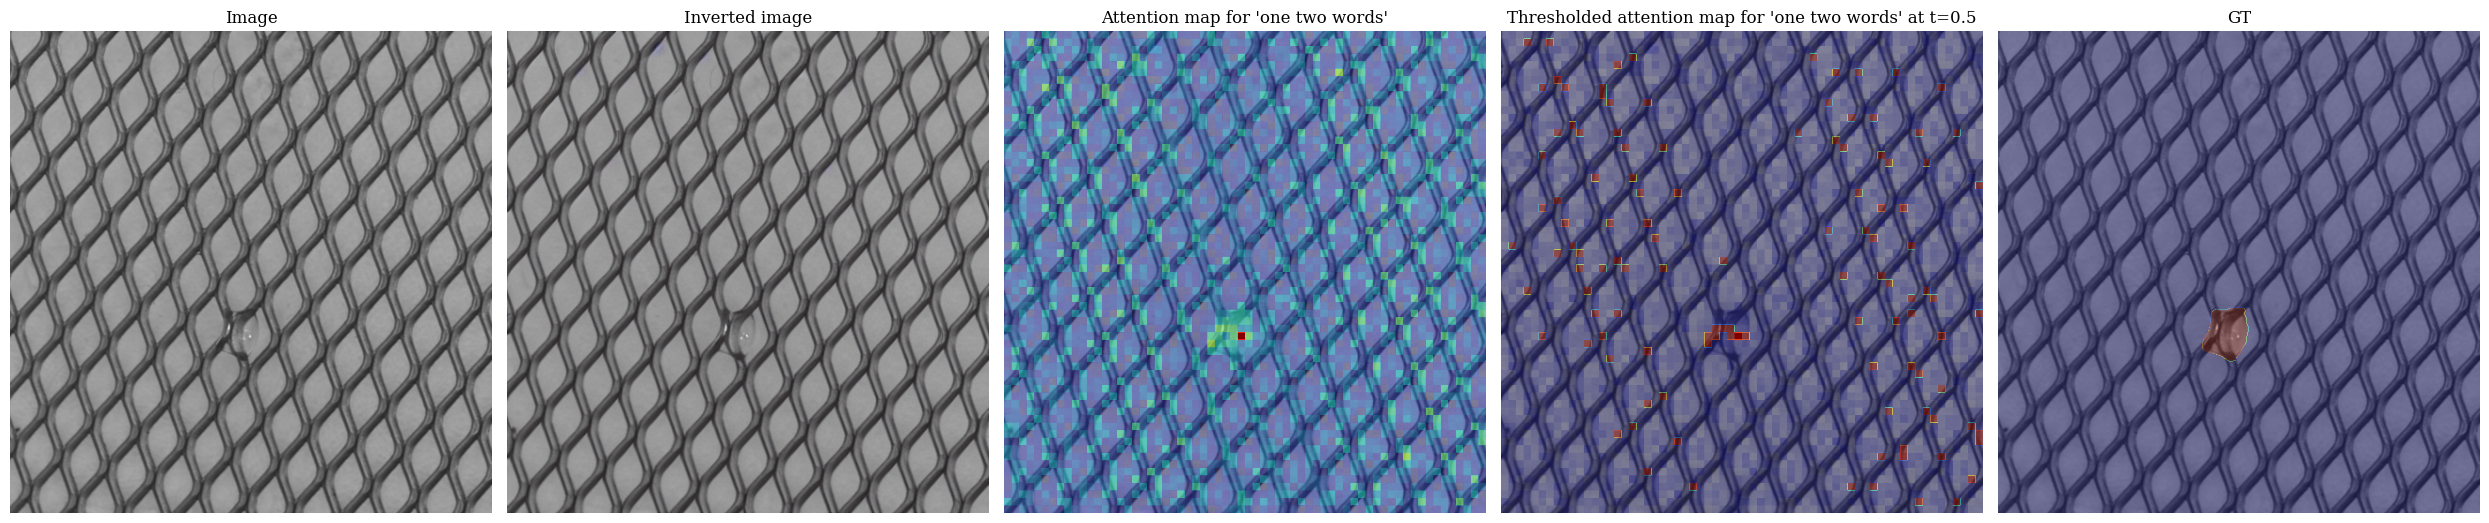

In [52]:
_, pil_images, _ = plot_word_attn_map(img, images[0], mask, attention_maps, damage_specific_prompt)

In [53]:
set_seed(420)

In [54]:
import wandb
import pandas as pd
import gc
gc.collect()
torch.cuda.empty_cache()

In [55]:
plt.ioff()

In [ ]:
calc_auroc = BinaryAUROC()
calculate_iou = BinaryJaccardIndex().to(device)
calculate_f1 = BinaryF1Score().to(device)

for cat in ['grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']:
    testset = MVTEC(root='/home/jovyan/work/nfs/mvtec/mvtec', train=False, transform=transform,
                    mask_transform=mask_transform,
                        resize=im_shape, interpolation=interpol, category=cat)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False)

    # Each category has two types of images: good (label 1) or defective (label 0)
    classes = ('defective', 'good')
    
    # damage prompt
    damage_prompt = 'damage'
    
    config = {
        'category': cat,
        'damage_prompt': damage_prompt,
        'DDIM inversion scale': 1.0,
        'DDIM inversion steps': 200,
    }
    wandb.init(project="MVtecAD-ovam-baseline", entity="uofg", config=config)
    
    results_cat, results_damage, results_damage_type, results_control = [], [], [], []

    input_image_prompt = cat # MVTec category

    for i, (img, mask, label, damage_type) in enumerate(testloader):
        gc.collect()
        torch.cuda.empty_cache()
        
        start_latent = encode_to_latent(img) # encode
        inverted_latents = invert(start_latent, input_image_prompt, num_inference_steps=200, guidance_scale=1.) # DDIM invert
        
        # regenerate and hook activations
        with StableDiffusionHooker(pipe) as hooker:
            out = pipe(input_image_prompt, latents=inverted_latents[-1][None], num_inference_steps=200, guidance_scale=1.)
            images = out.images
        
        wandb.log({
            'image': wandb.Image(tensor2numpy(img)),
            'inverted image': wandb.Image(images[0]),
            'gt mask': wandb.Image(tensor2numpy(mask)),
        })

        ovam_evaluator = hooker.get_ovam_callable(
            expand_size=(512, 512)
        )
        
        # cross attn for category prompt
        with torch.no_grad():
            attention_maps = ovam_evaluator(input_image_prompt)
            attention_maps = attention_maps[0]
            
        fig, pil_images, worn_attn_norm_cat = plot_word_attn_map(img, images[0], mask, attention_maps, input_image_prompt)
        wandb.log({
            f'prompt/{input_image_prompt}': wandb.Image(pil_images[2]),
            f'prompt/{input_image_prompt}_thresh': wandb.Image(pil_images[3]),
            f'fig/{input_image_prompt}': wandb.Image(fig),
        })
        plt.close()
        
        iou_score_cat = calculate_iou((worn_attn_norm_cat>0.5).float(), mask.to(device).squeeze()).item()
        f1_score_cat = calculate_f1((worn_attn_norm_cat>0.5).float(), mask.to(device).squeeze()).item()
        auroc_cat = calc_auroc(worn_attn_norm_cat, mask.to(device).squeeze()).item()
        
        results_cat.append({
            'category': cat,
            'class': classes[label],
            'damage_type': damage_type[0],
            'f1': f1_score_cat,
            'iou': iou_score_cat,
            'auroc': auroc_cat,
        })
        
        # cross attn damage
        with torch.no_grad():
            attention_maps = ovam_evaluator(damage_prompt)
            attention_maps = attention_maps[0]
        
        fig, pil_images, worn_attn_norm_damage  = plot_word_attn_map(img, images[0], mask, attention_maps, damage_prompt)
        wandb.log({
            f'prompt/damage_prompt/{damage_prompt}': wandb.Image(pil_images[2]),
            f'prompt/damage_prompt/{damage_prompt}_thresh': wandb.Image(pil_images[3]),
            f'fig/damage_prompt/{damage_prompt}': wandb.Image(fig)
        })
        plt.close()

        iou_score_damage = calculate_iou((worn_attn_norm_damage>0.5).float(), mask.to(device).squeeze()).item()
        f1_score_damage = calculate_f1((worn_attn_norm_damage>0.5).float(), mask.to(device).squeeze()).item()
        auroc_damage = calc_auroc(worn_attn_norm_damage, mask.to(device).squeeze()).item()

        results_damage.append({
            'category': cat,
            'class': classes[label],
            'damage_type': damage_type[0],
            'f1': f1_score_damage,
            'iou': iou_score_damage,
            'auroc': auroc_damage,
        })
        
        # cross attn damage specific 
        damage_specific_prompt = ' '.join(damage_type[0].split("_"))
        with torch.no_grad():
            attention_maps = ovam_evaluator(damage_specific_prompt)
            attention_maps = attention_maps[0]

        fig, pil_images, worn_attn_norm_damage_type  = plot_word_attn_map(img, images[0], mask, attention_maps, damage_specific_prompt)
        wandb.log({
            f'prompt/damage_type/{damage_type[0]}': wandb.Image(pil_images[2]),
            f'prompt/damage_type_thresh/{damage_type[0]}': wandb.Image(pil_images[3]),
            f'fig/damage_type/{damage_type[0]}': wandb.Image(fig)
        })
        plt.close()
        
        iou_score_damage_type = calculate_iou((worn_attn_norm_damage_type>0.5).float(), mask.to(device).squeeze()).item()
        f1_score_damage_type = calculate_f1((worn_attn_norm_damage_type>0.5).float(), mask.to(device).squeeze()).item()
        auroc_damage_type = calc_auroc(worn_attn_norm_damage_type, mask.to(device).squeeze()).item()
        wandb.log({f'gt': wandb.Image(pil_images[4])})

        results_damage_type.append({
            'category': cat,
            'class': classes[label],
            'damage_type': damage_type[0],
            'f1': f1_score_damage_type,
            'iou': iou_score_damage_type,
            'auroc': auroc_damage_type,
        })
        
        # cross attn control (random word)
        control_prompt = 'cat'
        with torch.no_grad():
            attention_maps = ovam_evaluator(control_prompt)
            attention_maps = attention_maps[0]

        fig, pil_images, worn_attn_norm_control  = plot_word_attn_map(img, images[0], mask, attention_maps, control_prompt)
        wandb.log({
            f'prompt/control': wandb.Image(pil_images[2]),
            f'prompt/control_tresh': wandb.Image(pil_images[3]),
            f'fig/control': wandb.Image(fig)
        })
        plt.close()

        iou_score_control = calculate_iou((worn_attn_norm_control>0.5).float(), mask.to(device).squeeze()).item()
        f1_score_control = calculate_f1((worn_attn_norm_control>0.5).float(), mask.to(device).squeeze()).item()
        auroc_control = calc_auroc(worn_attn_norm_control, mask.to(device).squeeze()).item()
        results_control.append({
            'category': cat,
            'class': classes[label],
            'damage_type': damage_type[0],
            'f1': f1_score_control,
            'iou': iou_score_control,
            'auroc': auroc_control,
        })
    df_results_cat = pd.DataFrame(results_cat)
    df_results_damage = pd.DataFrame(results_damage)
    df_results_damage_type = pd.DataFrame(results_damage_type)
    df_results_control = pd.DataFrame(results_control)
    
    metrics_cat = wandb.Table(dataframe=df_results_cat)
    metrics_damage = wandb.Table(dataframe=df_results_damage)
    metrics_damage_type = wandb.Table(dataframe=df_results_damage_type)
    metrics_control = wandb.Table(dataframe=df_results_control)

    wandb.log({
        "metrics/category": metrics_cat,
        "metrics/damage": metrics_damage,
        "metrics/damage_type": metrics_damage_type,
        "metrics/control": metrics_control,
        "f1_cat": df_results_cat.mean()['f1'],
        "f1_damage": df_results_damage.mean()['f1'],
        "f1_damage_type": df_results_damage_type.mean()['f1'],
        "f1_control": df_results_control.mean()['f1'],
        "iou_cat": df_results_cat.mean()['iou'],
        "iou_damage": df_results_damage.mean()['iou'],
        "iou_damage_type": df_results_damage_type.mean()['iou'],
        "iou_control": df_results_control.mean()['iou'],
        "auroc_cat": df_results_cat.mean()['auroc'],
        "auroc_damage": df_results_damage.mean()['auroc'],
        "auroc_damage_type": df_results_damage_type.mean()['auroc'],
        "auroc_control": df_results_control.mean()['auroc'],
    })
    
    wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

In [65]:
wandb.finish()

In [60]:
df_results_cat.mean()['f1']

0.08292322605848312

In [55]:
df_results_damage

category      class   damage_type        f1       iou     auroc
0   bottle  defective  broken_small  0.093228  0.048893  0.952769